In [2]:
import gym

from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy, CnnPolicy, CnnLstmPolicy, CnnLnLstmPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C

from gym.utils import seeding
from stable_baselines.common.env_checker import check_env
import numpy as np

from ads_utils import load_data, plot, Environment
from tqdm import tqdm

In [3]:
INITIAL_BALANCE = 10_000
PAST_TICKS = 5

data = load_data([2])

'''NOTE: there is no train/test split yet'''            
fake = np.linspace(100, 200, len(data))
data['close1'] = fake
fake = np.linspace(200, 100, len(data))
data['close2'] = fake
fake = 10*np.sin(np.linspace(0, 3141.592, len(data))/50) + 20
data['close3'] = fake
fake = 100*np.sin(np.linspace(0, 3141.592, len(data))/50) + np.random.normal(1000, 50, len(data))
data['close4'] = fake
fake = np.random.normal(1000, 50, len(data))
data['close5'] = fake
fake = 1000 - np.abs(np.arange(0, len(data)) - len(data)/2) * 0.05
data['close6'] = fake
fake = np.random.normal(1000, 50, len(data)) - np.abs(np.arange(0, len(data)) - len(data)/2) * 0.05
data['close7'] = fake

envs = []
for col in ['close'] + [f'close{i}' for i in range(1, 8)]:
    env = Environment(data[col].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
    envs.append(env)

In [38]:
# Something to look into as some environments don't seem to be satisfactory
for i in range(8):
    try:
        check_env(envs[i])
    except:
        print(i)

0
2
4
5
7


# Initial training with various test plots

  0%|          | 0/8 [00:00<?, ?it/s]

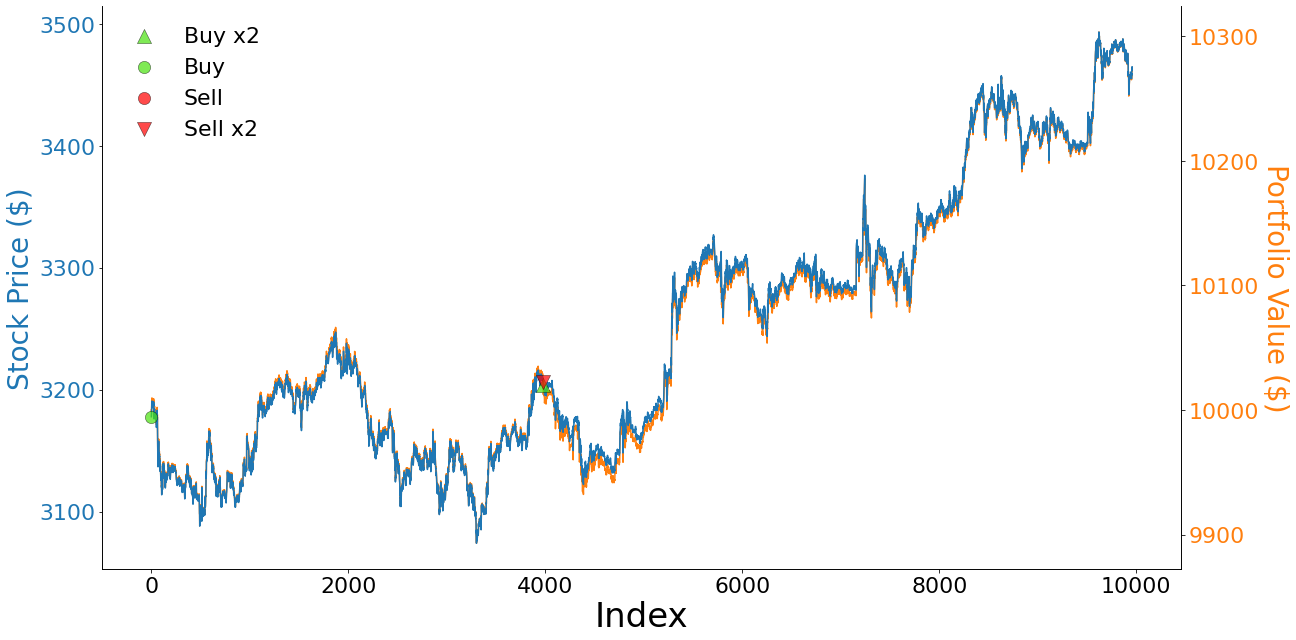

 12%|█▎        | 1/8 [02:03<14:22, 123.22s/it]

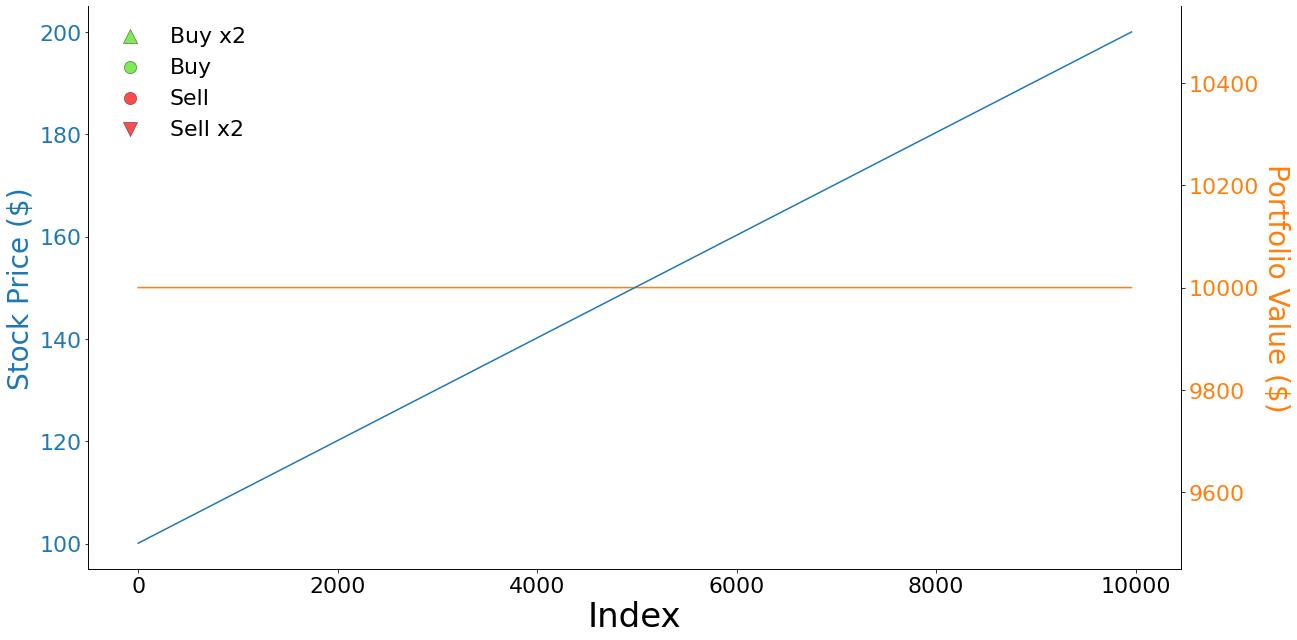

 25%|██▌       | 2/8 [21:00<42:43, 427.33s/it]

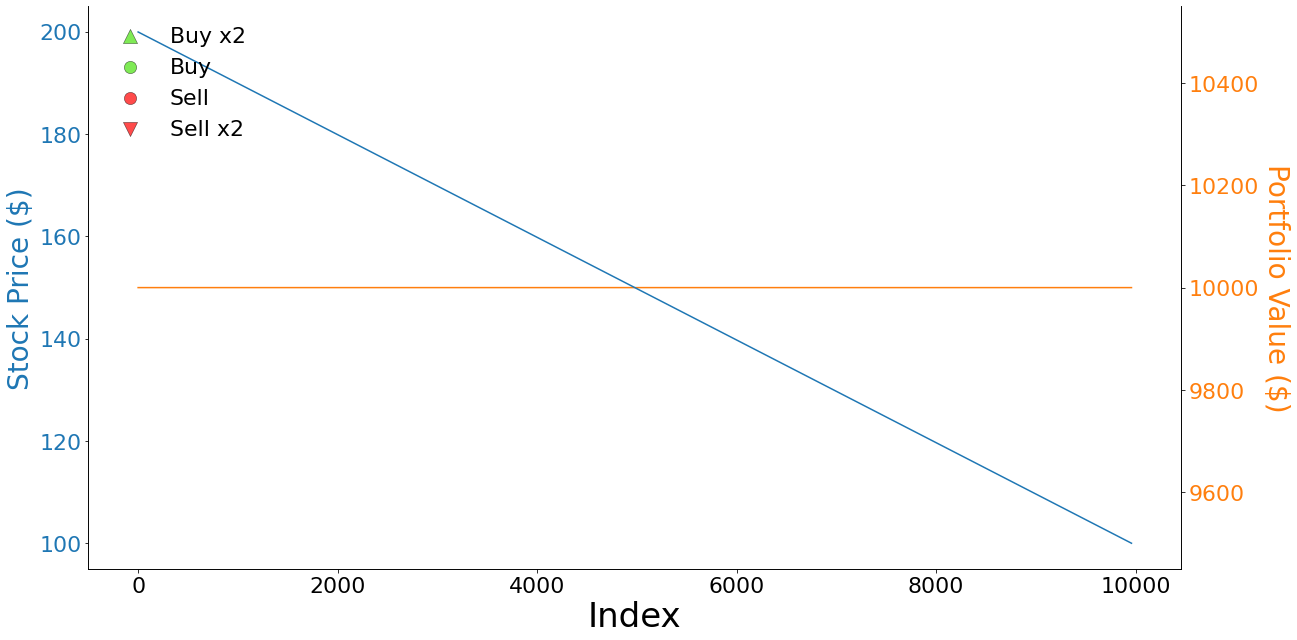

 38%|███▊      | 3/8 [23:12<28:13, 338.75s/it]

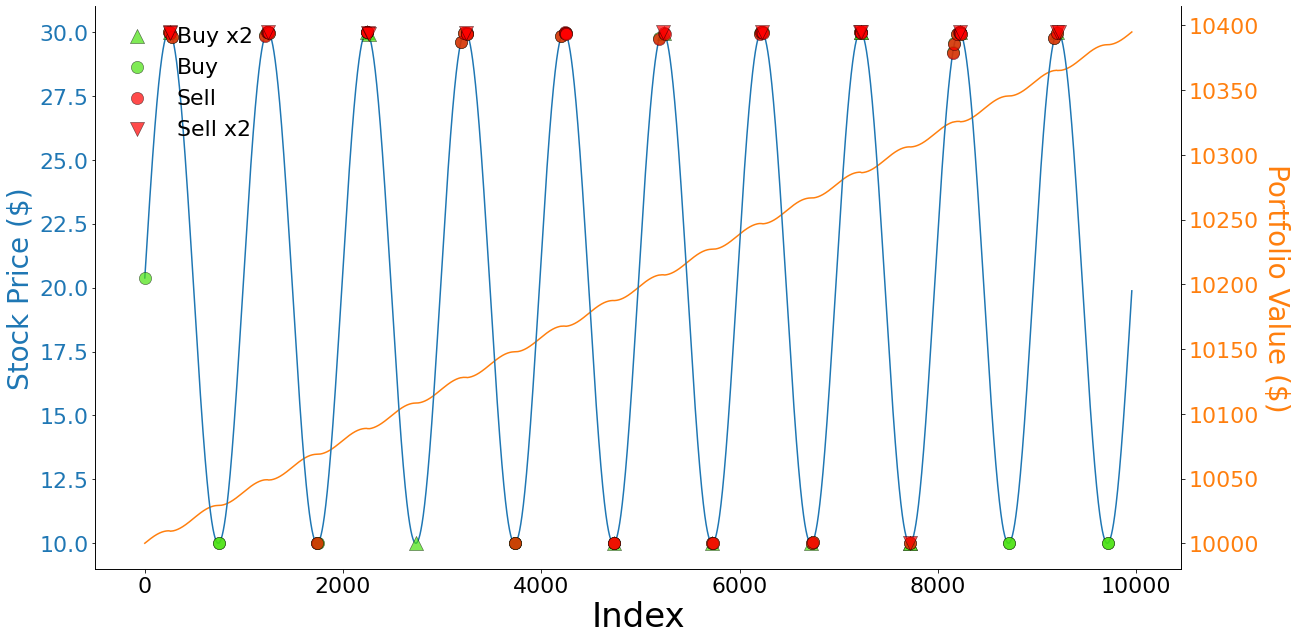

 50%|█████     | 4/8 [25:17<18:19, 274.83s/it]

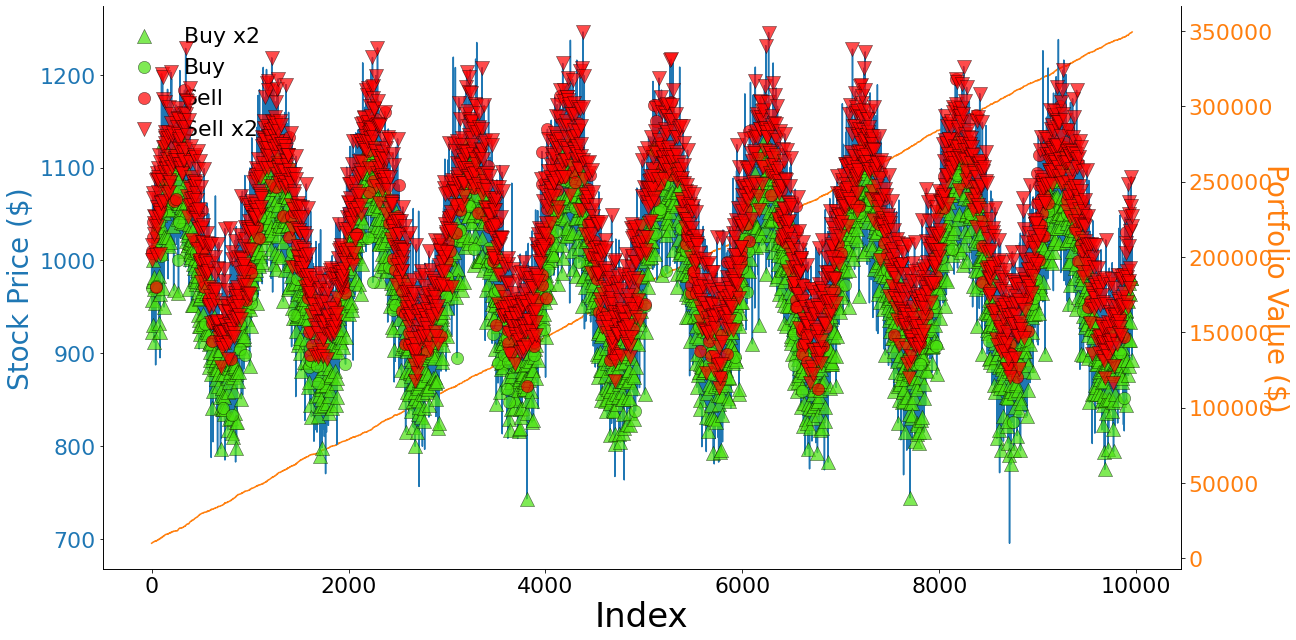

 62%|██████▎   | 5/8 [27:30<11:36, 232.12s/it]

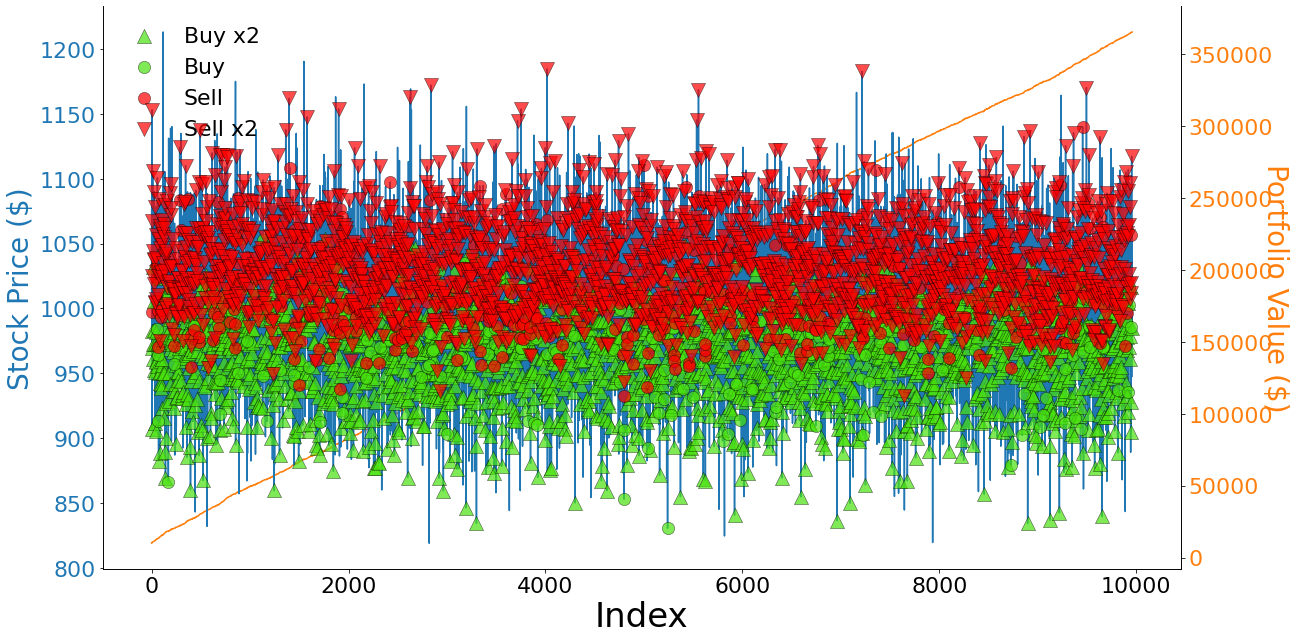

 75%|███████▌  | 6/8 [29:40<06:42, 201.40s/it]

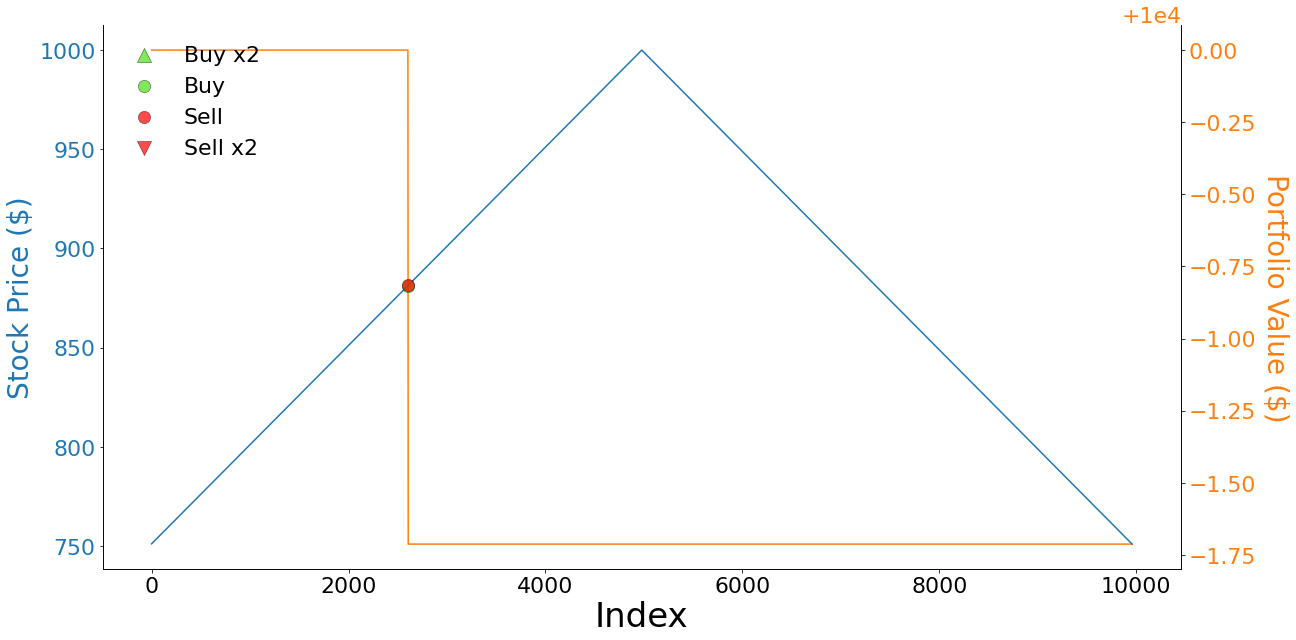

 88%|████████▊ | 7/8 [31:43<02:57, 177.95s/it]

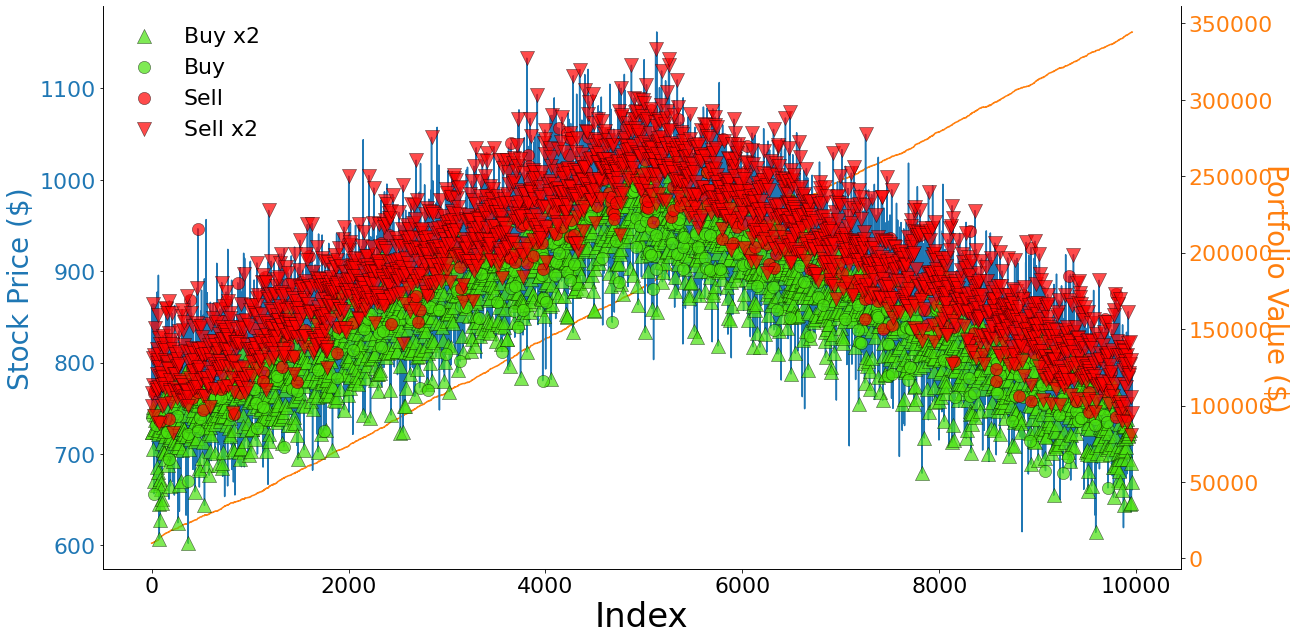

100%|██████████| 8/8 [33:53<00:00, 254.21s/it]


In [23]:
N_TIME_STEP = 250000

# TODO: Construct the environment
for env in tqdm(envs):
    env.reset()
    model = A2C(MlpPolicy, env, verbose=0)
    model.learn(total_timesteps=N_TIME_STEP)

    state = env.reset()
    portfolio_values = []
    prices = []
    actions = []
    
    for i in range(10_000):
        action, _ = model.predict(state)

        price, portfolio_value = env.get_data()
        actions.append(action)
        prices.append(price)
        portfolio_values.append(portfolio_value)

        state, reward, done, _ = env.step(action)
        if done:
            break
    plot(prices, actions, portfolio_values, right_y_adjust=1.1)



# Hyperparameter tuning with Wandb

In [4]:
import wandb

In [5]:
INITIAL_BALANCE = 10_000
PAST_TICKS = 5
N_TIME_STEP = 250000


def set_config(project_name="a2c", run_name=None, balance=INITIAL_BALANCE, portfolio_value=INITIAL_BALANCE, past_ticks=PAST_TICKS, 
               policy=MlpPolicy, env=envs[0], learning_rate=0.0007, total_timesteps=N_TIME_STEP, discount_factor=0.99):

    wandb.init(project=project_name)
    if run_name:
        wandb.run.name = run_name
    wandb.config.balance= balance
    wandb.config.portfolio_value = portfolio_value
    wandb.config.past_ticks= past_ticks
    wandb.config.policy = policy
    wandb.config.env = env
    wandb.config.learning_rate = learning_rate
    wandb.config.total_timesteps = total_timesteps
    wandb.config.discount_factor = discount_factor

In [28]:
## Basic training loop

# env = envs[0]
# env.reset()
# model = A2C(MlpPolicy, env, verbose=0)
# model.learn(total_timesteps=N_TIME_STEP)

# state = env.reset()
# portfolio_values = []
# prices = []
# actions = []

# for i in range(10_000):
#         action, _ = model.predict(state)

#         price, portfolio_value = env.get_data()
#         actions.append(action)
#         prices.append(price)
#         portfolio_values.append(portfolio_value)

#         state, reward, done, _ = env.step(action)
#         wandb.log({'reward': reward, 'portfolio_value': portfolio_value})
#         if done:
#             break

## n_time_step

In [16]:
t_steps = [5000, 10000, 15000, 25000, 30000, 35000, 40000, 250000]

In [17]:
# Training loop where parameters are logged

for t_step in t_steps:
    set_config(project_name='a2c-total-steps', 
               run_name=f'Total-Step {t_step}', 
               total_timesteps = t_step)
    
    env = envs[0]
    env.reset()
    model = A2C(MlpPolicy, env, verbose=0)
    model.learn(total_timesteps=t_step)

    state = env.reset()
    portfolio_values = []
    prices = []
    actions = []

    for i in range(10_000):
        action, _ = model.predict(state)

        price, portfolio_value = env.get_data()
        actions.append(action)
        prices.append(price)
        portfolio_values.append(portfolio_value)

        state, reward, done, _ = env.step(action)
        wandb.log({'reward': reward, 'portfolio_value': portfolio_value})
        if done:
            break

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## Learning Rate

In [42]:
learning_rates = np.arange(0.0003, 0.00145, 0.00005)

In [45]:

for r in learning_rates:
    set_config(project_name='a2c-learning-rates', 
               run_name=f'Learning rate - {r}', 
              learning_rate=r)
    
    env = envs[0]
    env.reset()
    model = A2C(MlpPolicy, env, verbose=0, learning_rate=r)
    model.learn(total_timesteps=40000)

    state = env.reset()
    portfolio_values = []
    prices = []
    actions = []

    for i in range(10_000):
        action, _ = model.predict(state)

        price, portfolio_value = env.get_data()
        actions.append(action)
        prices.append(price)
        portfolio_values.append(portfolio_value)

        state, reward, done, _ = env.step(action)
        wandb.log({'reward': reward, 'portfolio_value': portfolio_value})
        if done:
            break

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## Discount Factor

In [51]:
gammas = np.arange(0, 1.1, 0.1)


for g in gammas:
    set_config(project_name='a2c-discount-factor', 
               run_name=f'discount-factor - {g}', 
              discount_factor=g)
    
    env = envs[0]
    env.reset()
    model = A2C(MlpPolicy, env, verbose=0, gamma=g)
    model.learn(total_timesteps=40000)

    state = env.reset()
    portfolio_values = []
    prices = []
    actions = []

    for i in range(10_000):
        action, _ = model.predict(state)

        price, portfolio_value = env.get_data()
        actions.append(action)
        prices.append(price)
        portfolio_values.append(portfolio_value)

        state, reward, done, _ = env.step(action)
        wandb.log({'reward': reward, 'portfolio_value': portfolio_value})
        if done:
            break

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## Policy

In [29]:
# Doesn't really work so far due to environment issues
# policies = [MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy, CnnPolicy, CnnLstmPolicy, CnnLnLstmPolicy]
policies = [MlpPolicy, CnnPolicy]

In [31]:
# Training loop where parameters are logged

for p in policies:
    set_config(project_name='a2c-policies', 
               run_name=f'{p}', 
               total_timesteps = 40000)
    
    env = envs[0]
    env.reset()
    model = A2C(p, env, verbose=0)
    model.learn(total_timesteps=40000)

    state = env.reset()
    portfolio_values = []
    prices = []
    actions = []

    for i in range(10_000):
        action, _ = model.predict(state)

        price, portfolio_value = env.get_data()
        actions.append(action)
        prices.append(price)
        portfolio_values.append(portfolio_value)

        state, reward, done, _ = env.step(action)
        wandb.log({'reward': reward, 'portfolio_value': portfolio_value})
        if done:
            break

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


IndexError: list index out of range

## Sweep

In [30]:
sweep_config = {
  "name": "Sweep test",
  "method": "grid",
  "parameters": {
      "learning_rate": {
            "values": [0.01, 0.001, 0.0001, 0.00001]
        },
      "gamma": {
            "values": [0.5, 0.7, 0.9, 0.99, 0.999]
        },
      "n_steps": {
          "values": [10, 50, 70, 100]  
        },
      "momentum": {
          "values": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
      }
    }
}


In [31]:
sweep_id = wandb.sweep(sweep_config, entity="ads", project="a2c-sweep-all-params")

Create sweep with ID: varm0v16
Sweep URL: https://wandb.ai/ads/a2c-sweep-all-params/sweeps/varm0v16


In [32]:
# def train():
#     run = wandb.init()
#     print("config:", dict(run.config))
#     for epoch in range(35):
#         print("running", epoch)
#         wandb.log({"metric": run.config.param1, "epoch": epoch})
#         time.sleep(1)

# wandb.agent(sweep_id, function=train)

In [33]:
def train():
    run = wandb.init()
    print("config:", dict(run.config))
    
    env = envs[0]
    env.reset()
    model = A2C(MlpPolicy, env, verbose=0, 
                learning_rate=run.config.learning_rate, 
                gamma=run.config.gamma,
                n_steps=run.config.n_steps,
                momentum=run.config.momentum
               )
    model.learn(total_timesteps=40000)

    state = env.reset()
    portfolio_values = []
    prices = []
    actions = []

    for i in range(10_000):
        action, _ = model.predict(state)

        price, portfolio_value = env.get_data()
        actions.append(action)
        prices.append(price)
        portfolio_values.append(portfolio_value)

        state, reward, done, _ = env.step(action)
        wandb.log({'reward': reward, 'portfolio_value': portfolio_value})
        if done:
            break

In [ ]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: trronztb with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: tutzr9up with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: od8xibg2 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: 5wi4a2t6 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: 3x6rqoqx with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: 5gmuysv2 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: byuwqs3x with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: 9j0hdvu4 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: qkhbz12o with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: m8u4mv0q with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: b4pchqig with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: pj8yiqzo with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: heea6frl with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: 1xnnek8h with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: 7ok9tsg4 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: 3yicr03x with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: 9esk7mn1 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: 8skxwz4u with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 50}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eetb7we6 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 70}


wandb: Agent Starting Run: d8fq511f with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: etgxvqvw with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2zs7p871 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: toh7vrho with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: w8dnzvba with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: e7262axf with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: awa8cqlq with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: 6uulg1dy with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 70}


wandb: Agent Starting Run: nl3gz6j9 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 100}


wandb: Agent Starting Run: uf74dhot with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 10}


wandb: Agent Starting Run: tsglfd4l with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: 5fi88tai with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: y0v2swqi with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: vdjp6two with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: 2bfd1ka0 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: 58pgorvx with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: bvb8tlxx with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: c5xlzdl0 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 183lcfd7 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: axjfeze2 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: vl90j4hp with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: bisd7xn3 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: n37ankck with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: ewel8664 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: cx566xvr with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: 5d3zo1gv with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: l5d8idju with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: bdpzc7yr with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: or67psi7 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: yj40ue9m with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: 1u9kg8ck with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 50}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: moer9fe6 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: exbqxpty with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: mbigtdv0 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: 2swfdooi with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: w493br8v with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sphlorcu with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: buq7uhf9 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: 4vo8utxi with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: ek61y2ks with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: e6kse72m with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: 3hao9mue with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: hyselda4 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: zcinqi4p with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: srw6s4zr with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 100}


wandb: Agent Starting Run: 41tft7a2 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zdsfujeb with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: hnafo448 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: 3qatqcb6 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: ow6d948g with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: js2foekc with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 50}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 34609001 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: 5eomyinw with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: obymp76u with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: hg9uhb7w with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: 8g7yiz1a with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: wa9m71zs with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: 3n7koq1l with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: jmzgxoj2 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: w8gjaczc with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0xqcfask with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: fxazidwy with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: 7c49pg5y with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: bbwbjcb6 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: 1gbdeuho with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: js41gr3f with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: 4m73uo2o with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 50}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sf75m7pw with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: 91yjspwu with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: fx8namnl with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qq2lxsik with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: me83g35o with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9x0l2cah with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: du5dfz35 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: hkketaeu with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: aqdt1xif with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: ldya9at5 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: erpmyll6 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: wgakphxt with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: r8kzcftf with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 70}


wandb: Agent Starting Run: afhndbbz with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 100}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 21mnwg1p with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 10}


wandb: Agent Starting Run: 4iugmtgi with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: td5knwf0 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: gsm8bllt with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: n5o5qggl with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: yjc7n4xu with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: yjoa7acq with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: 336b059k with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: eza7jhib with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: 29sopa1j with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: c91kh56x with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: c27jlpr4 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: 9x5pijp4 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65sqkzi1 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: pgmf82xi with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6uobe9lq with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: 58o3m004 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: 2zoeyzmx with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: sb9xy4ao with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: 7i1g2572 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: 5x58bb7p with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: 2ddedimz with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: u57vmgdg with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: aynagq4y with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: bq6cb6be with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: owjkzg43 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: n8vo5z48 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 70}


wandb: Agent Starting Run: 8kxnkiwb with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: vidurugd with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: dn3btgl7 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: 6obsub3i with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: sjzjhv3z with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: eq572fiu with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: 6eamow5x with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: atyv6zcu with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ih0ggvaq with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 100}


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 7yd02vw5 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 10}


wandb: Agent Starting Run: cnx18uv4 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: t1jrp6mb with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: 7u96oo0l with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: z1v59t6g with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: c9ua8sdv with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: 33b3tuh2 with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: 6ru2x89o with config:
wandb: 	gamma: 0.5
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.5, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: pbwj9g5q with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: 4a8189f8 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: n43etryl with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: on5lc8o9 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: 30c1ium6 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: y8ymwu3r with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 50}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a4p3ksuz with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: 2nhq39hv with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: aeg1jcay with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: rd6n6if0 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: d6ly0fqi with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: 2uis4dhn with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: skxk2qbw with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: t9uediuo with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: ibedikbo with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: bj5bjujk with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: vbnm51sz with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: b3zaiz13 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: au7hayev with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 70}


wandb: Agent Starting Run: 6r0sjcsh with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 100}


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: qz4hg0m6 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: 8gbxxaaa with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: t50pwvlz with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: 5ik7w9o1 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: 66hn0vqe with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: x2k1a6ef with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: wj8ug8zi with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 70}


wandb: Agent Starting Run: 0fgqn169 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 100}


wandb: Agent Starting Run: 8v5rz0o8 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 10}


wandb: Agent Starting Run: v4q1t7cg with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: a8e0r30t with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: elchdx8c with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: yoypl16o with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: bkvpuuya with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: 54sfpmcl with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: w1dvfcyv with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: qdqo6z7q with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: pmyz3bzl with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: 516itupt with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: 4y9av46p with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: k08gfxdz with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: kgovamgn with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: sw1pw3z3 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: 90acgzzb with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: 6i5n3mm2 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: 86809azq with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: zuh1y86t with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: uxhrsisf with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: xi68bq7b with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s3n0a8fh with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: 42dipk32 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: if2bd6el with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: lik2k1va with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: 7tt2080b with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: nkvepamy with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: euxsjpgn with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 100}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gghkcewe with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: cgrt3m4a with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: ipqn8ggr with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: em8ckjs6 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: duarku2y with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: 7xuhzcs6 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: lslw5btn with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 70}


wandb: Agent Starting Run: l1i5i3k0 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 100}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rqc7lre9 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 10}


wandb: Agent Starting Run: q2bl91gq with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: zxjjmo4c with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: cke0kl9c with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: wh7likw4 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: lefe8uwg with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: o6se8zmd with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: dwojf55t with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.001, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: af96k50j with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: thprmz90 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: 4i918dmx with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: xpy0wvrj with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: p0bk87lv with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: gpar88o3 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: h0qooqrm with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: pw78bk1q with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: v33l2473 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: 0y8miwhw with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: j87tze2c with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: yajh9cl7 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: yd69y66d with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: rjzrubkw with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: iknt2wgq with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: hv2x5kbe with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: di3orbfx with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: udn4huoe with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: wabqmmt4 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 70}


wandb: Agent Starting Run: 7qkpnd0s with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: 975kvetg with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: 1o3ero3d with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: 3bdwk5sw with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i0n2f92p with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: yd9iamqb with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: np877gp1 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: dwz37ad8 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 70}


wandb: Agent Starting Run: hdpnjbxp with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.7, 'n_steps': 100}


wandb: Agent Starting Run: 8fzez1hp with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: go8akbew with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: 0lcco6pw with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: ymbmo0l9 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: a1w4aqbn with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: fdrsszoh with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: rrb1akv5 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: dhqmxkra with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 0.0001, 'momentum': 0.9, 'n_steps': 100}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jagxh75x with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: q3jgpidr with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: 6jlxsxsn with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: mr7057x3 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: nsxoxf55 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: myx7vu1n with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: 6i9e0dqg with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: lwr43zop with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: 09aqfv77 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: m0s04k1t with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: sw2r2hrp with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: ykil6z2z with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: weveiwf8 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: gu874c0f with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: nllleuc1 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: zfkmdkk0 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: qfcj5qvp with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: m8xfdtfq with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: goa5sg11 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 70}


wandb: Agent Starting Run: fmwx7tgz with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: 1exrntyc with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: 3v6il8j2 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: obd21lme with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: ccscsiq3 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: 4srkqjot with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: 7a07a898 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: f3441hjt with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j33usocc with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.7, 'n_steps': 100}


wandb: Agent Starting Run: s0k5nvcr with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post http://anaconda.default.svc.cluster.local/search: context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: przjy4xu with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: b6y6cz4x with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: g54zhpe2 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: 3zfw4h50 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: ozwgbmp1 with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: 9fl6d9sm with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: 26tw8tir with config:
wandb: 	gamma: 0.7
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.7, 'learning_rate': 1e-05, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: l2sxmw67 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: 54thpbwe with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: 9gql2cn9 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: el1lxn7e with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: eq1frif6 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 10}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7s8e24ds with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: cjsl9bsl with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: wpzs4gbp with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: 6u5s2aso with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: 8yy1t7c6 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: hxvms30k with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: zosb1vf3 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: zoy8k0ro with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: nz5k2okm with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: utlprcbu with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 70}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3faevwx1 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.4, 'n_steps': 100}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vpkchd0l with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: 8y6l5492 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: elaeyp3l with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 70}


wandb: Agent Starting Run: uqyngbjz with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: hwwgxnxa with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: xx08irmo with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: tzqfdpna with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: zbcsszo8 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: l6n2q5fg with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 10}


wandb: Agent Starting Run: ier4nknd with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 50}


wandb: Agent Starting Run: c8p2kmf9 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 70}


wandb: Agent Starting Run: l32rtfz2 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.7
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.7, 'n_steps': 100}


wandb: Agent Starting Run: hw7hkdb8 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 10}


wandb: Agent Starting Run: g96wfv7p with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 50}


wandb: Agent Starting Run: dcgfoy29 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 70}


wandb: Agent Starting Run: lr1lnd9k with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.8
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.8, 'n_steps': 100}


wandb: Agent Starting Run: q289aco5 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 10}


wandb: Agent Starting Run: k4ju62a4 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 50}


wandb: Agent Starting Run: fhr79hud with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 70}


wandb: Agent Starting Run: fg181kzm with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.01, 'momentum': 0.9, 'n_steps': 100}


wandb: Agent Starting Run: fgrhnhvn with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 10}


wandb: Agent Starting Run: 2zifulrs with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 50}


wandb: Agent Starting Run: 0xge0o67 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 70}


wandb: Agent Starting Run: popc2ss3 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.1
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.1, 'n_steps': 100}


wandb: Agent Starting Run: zwhqq8yh with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 10}


wandb: Agent Starting Run: ogxe5q9l with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 50}


wandb: Agent Starting Run: ywccqjal with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 70}


wandb: Agent Starting Run: v7wxlwio with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.2
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.2, 'n_steps': 100}


wandb: Agent Starting Run: olbh6y32 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 10}


wandb: Agent Starting Run: zca9gudl with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 50}


wandb: Agent Starting Run: kkymyp79 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 70}


wandb: Agent Starting Run: 0szt8nn0 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.3
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.3, 'n_steps': 100}


wandb: Agent Starting Run: 786ndjyh with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 10}


wandb: Agent Starting Run: y7p4z9e1 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 50}


wandb: Agent Starting Run: j9seu14g with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 70}


wandb: Agent Starting Run: t6ongjk0 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.4, 'n_steps': 100}


wandb: Agent Starting Run: tr6o6aeo with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 10}


wandb: Agent Starting Run: mzi4ch9y with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 50}


wandb: Agent Starting Run: y1022iia with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 70}


wandb: Agent Starting Run: xset25iv with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.5, 'n_steps': 100}


wandb: Agent Starting Run: 3jcw04l3 with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 10}


wandb: Agent Starting Run: 7cqk2t8o with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 50


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 50}


wandb: Agent Starting Run: pjlz3sxd with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 70


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 70}


wandb: Agent Starting Run: 7exmga0d with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	n_steps: 100


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.6, 'n_steps': 100}


wandb: Agent Starting Run: fsh3sqdp with config:
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.7
wandb: 	n_steps: 10


config: {'gamma': 0.9, 'learning_rate': 0.001, 'momentum': 0.7, 'n_steps': 10}
